# SVM模型

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import root_mean_squared_error
import torch
from joblib import dump, load

# 資料

In [2]:
# 讀取資料
data_incomplete = pd.read_csv(
    "ExampleTrainData(IncompleteAVG)/IncompleteAvgDATA_17.csv"
)
data_complete = pd.read_csv("ExampleTrainData(AVG)/AvgDATA_17.csv")

# 轉換 Serial 為時間戳並去掉秒數
data_incomplete["Timestamp"] = data_incomplete["Serial"].astype(str).str[:-2]
data_incomplete["Timestamp"] = pd.to_datetime(
    data_incomplete["Timestamp"], format="%Y%m%d%H%M"
)
data_incomplete = data_incomplete.set_index("Timestamp")

data_complete["Timestamp"] = data_complete["Serial"].astype(str).str[:-2]
data_complete["Timestamp"] = pd.to_datetime(
    data_complete["Timestamp"], format="%Y%m%d%H%M"
)
data_complete = data_complete.set_index("Timestamp")

# 提取所需欄位
features = [
    "WindSpeed(m/s)",
    "Pressure(hpa)",
    "Temperature(°C)",
    "Humidity(%)",
    "Sunlight(Lux)",
]
target = "Power(mW)"

# 合併資料
combined_data = pd.concat(
    [data_incomplete[features + [target]], data_complete[features + [target]]]
)
combined_data = combined_data.sort_index()


# 每一天單獨處理，僅填補早上 7 點到下午 5 點的時間段
filled_data = combined_data.copy()  # 複製原始資料，這樣不會破壞原始資料
# 確保填補資料框具有欄位
for day in pd.date_range(
    start=combined_data.index.min().date(),
    end=combined_data.index.max().date(),
    freq="D",
):
    # 設定填補範圍
    start_time = day.replace(hour=7, minute=0, second=0)
    end_time = day.replace(hour=16, minute=50, second=0)
    time_range_to_fill = pd.date_range(start=start_time, end=end_time, freq="10T")

    # 跳過 end_time 早於早上 9 點的天數
    if end_time < day.replace(hour=9, minute=0, second=0):
        continue

    # 在填補範圍內進行移動平均值補缺
    for time in time_range_to_fill:
        if time not in filled_data.index:
            # 將該時間點的缺失值填充為滑動窗口的均值
            # 獲取最近的五個時間點進行平均計算
            filled_data.loc[time] = 0
            window = filled_data.loc[:time].tail(4)  # 取出之前五個有效數據點
            if not window.empty:
                filled_data.loc[time] = window.mean()
            else:
                filled_data.loc[time] = 0  # 如果沒有有效數據，用 0 填補

# 最終的 filled_data 是僅針對早上 7 點到下午 5 點補全的資料
combined_data = filled_data.sort_index()


# 整理 x_train 和 y_train
x_train_list = []
y_train_list = []
review_day = 0

# 假設 combined_data 已經存在
day_count = 0
for day in pd.date_range(
    start=combined_data.index.min(), end=combined_data.index.max(), freq="D"
):
    # 從第n天開始計算
    if day_count < review_day:
        day_count += 1
        continue

    # 取得當天的資料
    day_data = combined_data.loc[
        day : day + timedelta(days=1) - timedelta(seconds=1)
    ]  # 取該天的資料

    # 確保取出的時間範圍是有效的
    morning_range = pd.date_range(
        start=day.replace(hour=7, minute=0, second=0),
        end=day.replace(hour=8, minute=50, second=0),
        freq="T",
    )
    evening_range = pd.date_range(
        start=day.replace(hour=9, minute=0, second=0),
        end=day.replace(hour=17, minute=0, second=0),
        freq="T",
    )

    # 提取當天 7點到9點的特徵資料
    x_day = day_data.loc[day_data.index.isin(morning_range)]

    # 9點到下午5點的目標資料
    y_day = day_data.loc[day_data.index.isin(evening_range), "Power(mW)"]

    # 加入前n天的完整資料
    for i in range(1, review_day + 1):
        prev_day = day - timedelta(days=i)
        prev_day_data = combined_data.loc[
            prev_day : prev_day + timedelta(days=1) - timedelta(seconds=1)
        ]

        # 如果前一天資料為空，跳過
        if prev_day_data.empty:
            break

        x_day = pd.concat([prev_day_data[features], x_day[features]])
    x_day = np.array(x_day)

    # 確保資料是非空的，然後儲存
    if x_day.size > 0 and y_day.size > 0:
        x_train_list.append(x_day[:, 1:])  # 儲存每個時間段的特徵值
        y_train_list.append(y_day)  # 儲存對應的目標值

# 訓練集和測試集

In [3]:
# 將 list 合併並轉換為 Tensor
x_train = np.array(x_train_list, dtype=np.float32)  # 確保資料形狀一致
y_train = np.array(y_train_list, dtype=np.float32)

x_train_tensor = torch.tensor(x_train)
y_train_tensor = torch.tensor(y_train)


# # 標準化
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

# 對特徵和目標進行標準化
x_train_standardized = scaler_features.fit_transform(
    x_train.reshape(-1, x_train.shape[-1])
).reshape(x_train.shape)

y_train_standardized = scaler_target.fit_transform(
    y_train.reshape(-1, 1)
).reshape(y_train.shape)

# 轉換為 Tensor
x_train_tensor = torch.tensor(x_train_standardized, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_standardized, dtype=torch.float32)

print(f"x_train shape: {x_train_tensor.shape}")
print(f"y_train shape: {y_train_tensor.shape}")
# (193, 72, 4)  (193, 48)

# 將 x_train_tensor 和 y_train_tensor 展平為 2D 格式
x_data = x_train_tensor.numpy().reshape(x_train_tensor.shape[0], -1)
y_data = y_train_tensor.numpy()

print(f"x_data shape: {x_data.shape}")  # (193, 288)
print(f"y_data shape: {y_data.shape}")  # (193, 48)



# 預測訓練集
test_data = pd.read_csv("ExampleTestData/upload.csv")
test_data.columns = ["date/time/id", "answer"]
date_list = []
time_list = []
station_id_list = []

for index in range(len(test_data)):
    date = str(test_data["date/time/id"][index])[:8]
    time = str(test_data["date/time/id"][index])[8:12]
    station_id = str(test_data["date/time/id"][index])[12:]

    date_list.append(date)
    time_list.append(time)
    station_id_list.append(station_id)

test_data["date"] = date_list
test_data["time"] = time_list
test_data["id"] = station_id_list

test_data.drop(["date/time/id"], axis=1, inplace=True)
station_filter = test_data["id"] == "17"
test_data = test_data[station_filter]
test_date = test_data["date"].value_counts().index

x_test_list = []
y_test_list = []
for day in pd.to_datetime(test_date):
    # 取得當天的資料
    day_data = combined_data.loc[
        day : day + timedelta(days=1) - timedelta(seconds=1)
    ]  # 取該天的資料

    # 確保取出的時間範圍是有效的
    morning_range = pd.date_range(
        start=day.replace(hour=7, minute=0, second=0),
        end=day.replace(hour=8, minute=50, second=0),
        freq="T",
    )
    evening_range = pd.date_range(
        start=day.replace(hour=9, minute=0, second=0),
        end=day.replace(hour=17, minute=0, second=0),
        freq="T",
    )

    # 提取當天 7點到9點的特徵資料
    x_day = day_data.loc[day_data.index.isin(morning_range)]


    # 加入前n天的完整資料
    for i in range(1, review_day + 1):
        prev_day = day - timedelta(days=i)
        prev_day_data = combined_data.loc[
            prev_day : prev_day + timedelta(days=1) - timedelta(seconds=1)
        ]

        # 如果前一天資料為空，跳過
        if prev_day_data.empty:
            break

        x_day = pd.concat([prev_day_data[features], x_day[features]])
    x_day = np.array(x_day)

    # 確保資料是非空的，然後儲存
    if x_day.size > 0:
        x_test_list.append(x_day[:, 1:])  # 儲存每個時間段的特徵值

x_test_tensor = torch.tensor(x_test_list, dtype=torch.float32)
y_test_tensor = torch.tensor(test_data["answer"].values, dtype=torch.float32)

x_test_standardized = scaler_features.transform(
    x_test_tensor.numpy().reshape(-1, x_test_tensor.shape[-1])
).reshape(x_test_tensor.shape)

x_test_flattened = x_test_standardized.reshape(x_test_standardized.shape[0], -1)

x_train shape: torch.Size([194, 12, 5])
y_train shape: torch.Size([194, 48])
x_data shape: (194, 60)
y_data shape: (194, 48)


C:\Users\mow20\AppData\Local\Temp\ipykernel_26324\1271742834.py:106: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  x_test_tensor = torch.tensor(x_test_list, dtype=torch.float32)


# 模型建置

In [4]:
# 初始化 SVM 和多輸出回歸器
svm_model = SVR(
    kernel = "rbf",
    C = 1, # 正則化參數
    epsilon = 0.1  # 目標值的允許偏差
)

# 使用 MultiOutputRegressor 包裝模型
multioutput_model = MultiOutputRegressor(svm_model)


# 滑動窗口分割
n_splits = 5  # 設定交叉驗證的分割數
tscv = TimeSeriesSplit(n_splits=n_splits)

# 儲存每個分割的結果
validation_scores = []

# Early Stopping 參數
patience = 10  # 忍耐次數
best_rmse = float("inf")
patience_counter = 0

best_model = None  # 用來保存最佳模型
for fold, (train_index, val_index) in enumerate(tscv.split(x_data)):
    print(f"\nFold {fold + 1}/{n_splits}")
    
    x_train, x_valid = x_data[train_index], x_data[val_index]
    y_train, y_valid = y_data[train_index], y_data[val_index]

    # 重新初始化模型以避免累積訓練
    multioutput_model = MultiOutputRegressor(
        SVR(kernel="rbf", C=1, epsilon=0.1)
    )

    multioutput_model.fit(x_train, y_train)
    y_pred = multioutput_model.predict(x_valid)
    score = root_mean_squared_error(y_valid, y_pred)
    validation_scores.append(score)
    
    print(f"Validation RMSE: {score}")

    # 保存最佳模型
    if score < best_rmse:
        best_rmse = score
        patience_counter = 0  # 重置耐心計數器
        best_model = multioutput_model
        dump(best_model, "best_model.joblib")  # 保存模型
        print("Saved best model.")
    else:
        patience_counter += 1
        print(f"Early stopping patience counter: {patience_counter}/{patience}")
    
    if patience_counter >= patience:
        print(f"Early stopping triggered at fold {fold + 1}/{n_splits}")
        break

# 計算 RMSE 的平均值和標準差
mean_rmse = np.mean(validation_scores)
print(f"Average RMSE: {mean_rmse}")


# 載入保存的最佳模型
best_model = load("best_model.joblib")

# 使用最佳模型進行預測
y_test_pred = best_model.predict(x_test_flattened)


# 反標準化
y_pred_original = scaler_target.inverse_transform(y_test_pred.reshape(-1, 1)).flatten()


Fold 1/5
Validation RMSE: 0.1396525352319988
Saved best model.

Fold 2/5
Validation RMSE: 0.14674713547389892
Early stopping patience counter: 1/10

Fold 3/5
Validation RMSE: 0.09925088557714974
Saved best model.

Fold 4/5
Validation RMSE: 0.1251201675396589
Early stopping patience counter: 1/10

Fold 5/5
Validation RMSE: 0.16475816522027367
Early stopping patience counter: 2/10
Average RMSE: 0.135105777808596


# 模型結果

預測數據: [ 143.45001499  157.25906886  216.16622396  302.13680708  301.58171779
  326.21506918  325.09313512  345.14552921  381.61113754  365.68646792
  378.3622899   203.4758235   185.20214599  179.25464793  201.88508576
  273.6011962   199.9974892   137.54236671  143.76563848  181.64569247
  200.0146037   216.4186596   199.18298395  165.63604841  139.12654928
   11.12003093  100.86312162   99.27084701   89.61740965  168.49727345
  153.4730287   106.95734225  197.97736178  151.67856424  147.8169383
  109.669995     39.16999874   40.11000174   27.89999904   22.6449996
   21.68000086   23.56999888   11.23499994   10.17500041   10.06999929
    6.57499962    5.88999987    3.72999995  108.14331923   51.56974788
  108.11072856  136.84476073  123.12300287  136.75812952   75.28187075
  109.33613822   74.22878139  134.69339539  143.66100444   59.31359989
  139.41226849  106.4426083    75.11278412   71.87732155  162.5537504
  160.43475722  167.82822578  127.98819223  180.80800818  187.83039588
  1

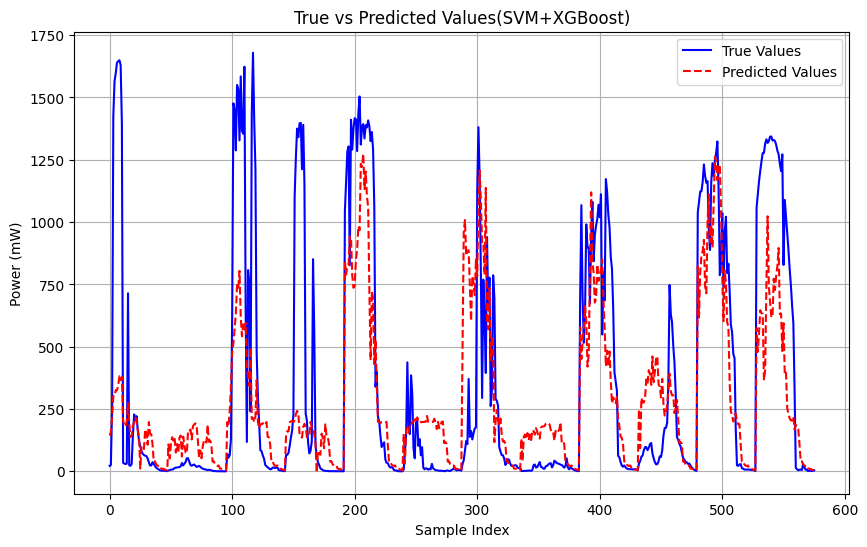

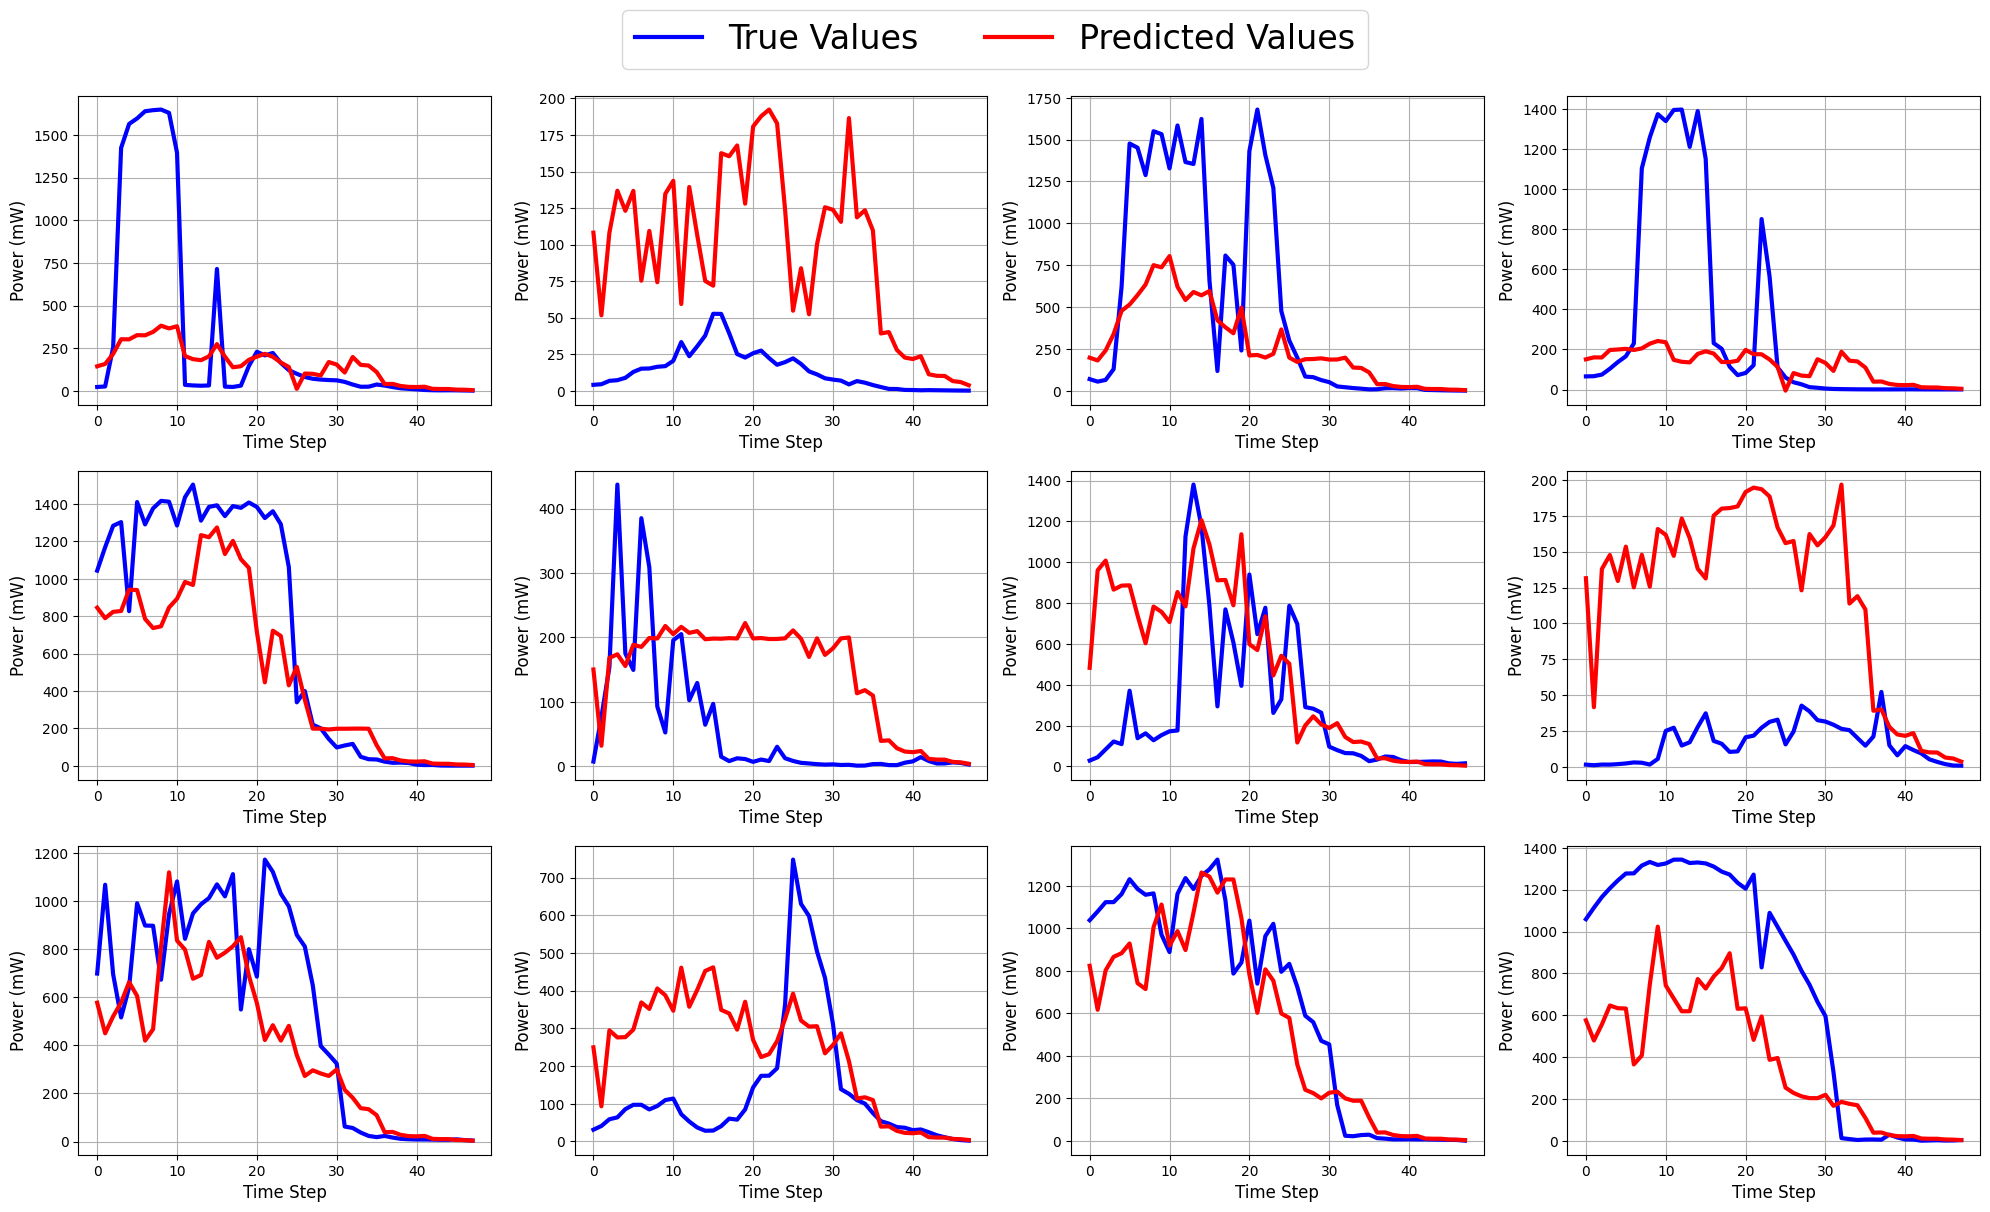

In [6]:
# 載入保存的最佳模型
best_model = load("best_model.joblib")

# 使用最佳模型進行預測
y_test_pred = best_model.predict(x_test_flattened)


# 反標準化
y_pred_original = scaler_target.inverse_transform(y_test_pred.reshape(-1, 1)).flatten()

# 查看部分預測結果
print("預測數據:", y_pred_original)

def calculate_total_score(y_true, y_pred):
    if isinstance(y_true, torch.Tensor):
        y_true = y_true.numpy()
    if isinstance(y_pred, torch.Tensor):
        y_pred = y_pred.numpy()
    return np.sum(np.abs(y_pred - y_true))

print(calculate_total_score(y_test_tensor, y_pred_original))



import matplotlib.pyplot as plt

# 轉換為 NumPy 數組
y_test_numpy = y_test_tensor.numpy()
y_pred_numpy = y_pred_original

# 視覺化預測結果 vs 實際結果
plt.figure(figsize=(10, 6))
plt.plot(y_test_numpy, label='True Values', color='blue')
plt.plot(y_pred_numpy, label='Predicted Values', color='red', linestyle='--')
plt.title('True vs Predicted Values(SVM+XGBoost)')
plt.xlabel('Sample Index')
plt.ylabel('Power (mW)')
plt.legend()
plt.grid(True)
plt.show()


fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 12))  # 3行4列的子圖
axes = axes.flatten()  # 展平成一維數組，方便索引

# 分成每一天
for i in range(12):
    start_idx = i * 48
    end_idx = (i + 1) * 48
    
    # 實際值預測值
    y_test_day = y_test_numpy[start_idx:end_idx]
    y_pred_day = y_pred_numpy[start_idx:end_idx]
    
    # 畫圖
    axes[i].plot(y_test_day, label='True Values', color='blue', linewidth=3)
    axes[i].plot(y_pred_day, label='Predicted Values', color='red', linewidth=3)
    axes[i].set_xlabel('Time Step', fontsize=12)  # x軸標籤
    axes[i].set_ylabel('Power (mW)', fontsize=12)  # y軸標籤
    axes[i].grid(True)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', fontsize=24, ncol=2, bbox_to_anchor=(0.5, 1.02))

# 子圖間距
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()